In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from src.cache import cache

set_matplotlib_formats("svg")

In [6]:
from src.models.propensity_scores.nlp.basic import get_data

y = get_data().y
pos = y.sum()
neg = len(y) - pos
print(f"Positive: {pos}, Negative: {neg}")
# calculate expected f1 score for random guessing
from sklearn.metrics import f1_score

f1_score(y, [1] * len(y))

Positive: 890, Negative: 13267


0.11829600584834188

In [1]:
from src.models.propensity_scores.nlp.basic import (
    f1_augmented,
    f1_combi,
    f1_text,
    f1_ts,
)

f1_ts()
f1_text(cutoff=1000)
# f1_combi(cutoff=1000)
# f1_augmented(cutoff=1000)

Cross-validated F1 score: 0.185 +/- 0.060
Cross-validated F1 score: 0.157 +/- 0.060


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

<Axes: >

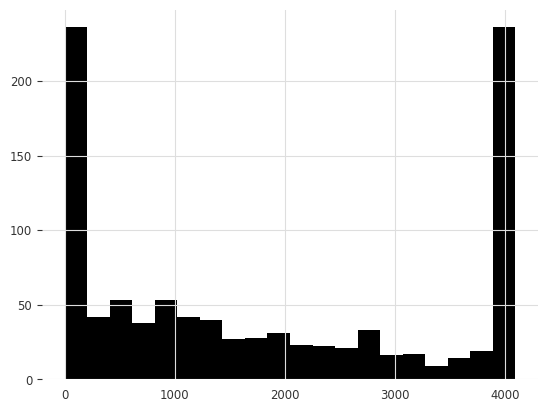

In [23]:
d = get_data(cutoff=500)
texts = d._X_text["text_lag0"]
texts.sample(1000).apply(lambda x: len(tokenizer.tokenize(x))).clip(0, 4096).hist(
    bins=20
)

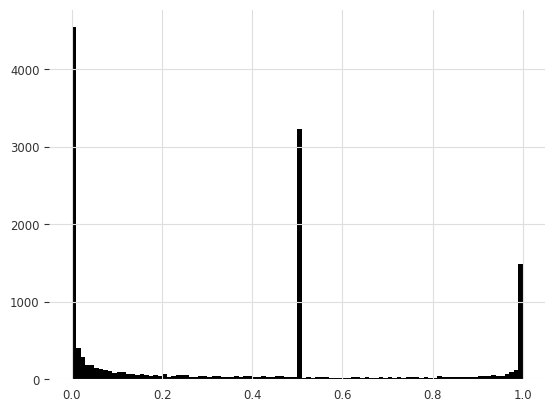

In [8]:
import matplotlib.pyplot as plt

from src.models.propensity_scores.nlp.basic import get_text_probas

X_text_proba = get_text_probas(cutoff=500)
plt.hist(X_text_proba[:, 1], bins=100)
plt.show()

In [13]:
proba = X_text_proba[:, 0]
sum((proba < 0.95) & (proba > 0.5)) / len(proba)

In [ ]:
df["text_lag-1"].str.split().str.len().describe()

count    14157.000000
mean      2054.008264
std       1394.894754
min          0.000000
25%        873.000000
50%       2008.000000
75%       2954.000000
max       7889.000000
Name: text_lag-1, dtype: float64

In [7]:
from src.features.aggregation import all_regions

{name: df["occ_protest"].iloc[:60].sum() for name, df in all_regions(ignore_group=True)}

{'Bayern': 14,
 'Berlin': 9,
 'Brandenburg': 0,
 'Hamburg': 9,
 'Hessen': 7,
 'Niedersachsen': 7,
 'Nordrhein-Westfalen': 16,
 'Rheinland-Pfalz': 2,
 'Saarland': 0,
 'Sachsen': 2,
 'Sachsen-Anhalt': 1,
 'Schleswig-Holstein': 3,
 'Thüringen': 6}

In [8]:
from src.models.propensity_scores.nlp.basic import get_data

d = get_data()
d.y.iloc[:1000].value_counts()

0    923
1     77
Name: occ_protest, dtype: int64

/Users/david/Repositories/protest-impact/.venv/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/david/Repositories/protest-impact/.venv/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for de

Cross-validated F1 score: 0.147 +/- 0.094


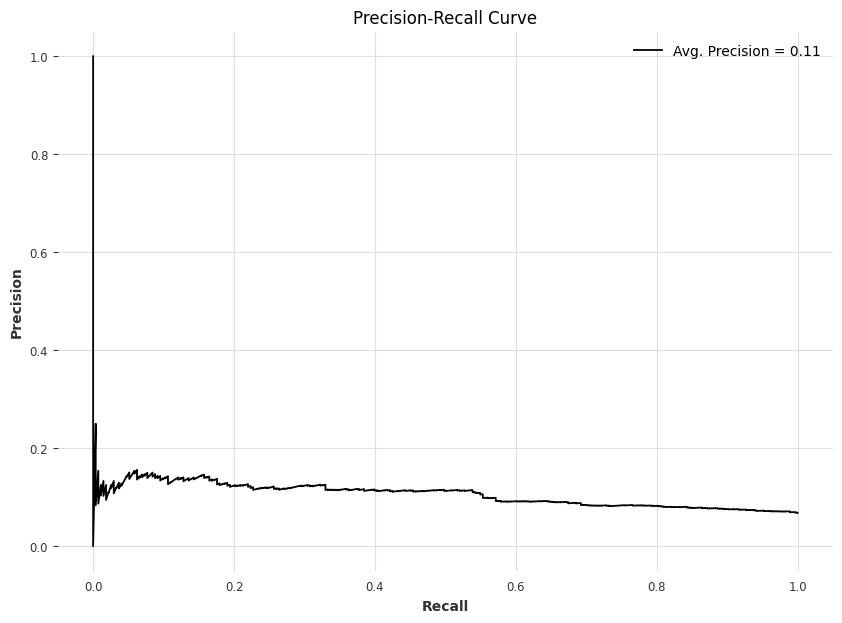

In [1]:
from src.models.propensity_scores.nlp.embeddings import (
    f1_embeddings,
    precision_recall_curve,
)

f1_embeddings()
precision_recall_curve()

input lenghts:

- electra: 128 tokens
- bert: 512 tokens
- llama 2: 4096 tokens